In [27]:
from pandas import read_csv

load_signal_trends = read_csv(filepath_or_buffer="data/results/tables/harmonic_load_signal_trends.csv")
Love_numbers_table = read_csv(filepath_or_buffer="data/results/tables/Love_numbers.csv")
option_names = ["use_long_term_anelasticity", "use_short_term_anelasticity"]
for option_name in option_names:
    Love_numbers_id_condition = Love_numbers_table["ID"][Love_numbers_table[option_name]].values  # TODO: Modify.
    load_signal_trends[option_name] = [id in Love_numbers_id_condition for id in load_signal_trends["Love_numbers_ID"].values]
grouped_df = load_signal_trends.groupby(option_names)["ocean_mean_step_3"].aggregate(["mean", "std", "max", "min"])
grouped_df["Anelasticity"] = [
    "short-term and long-term" if short_term and long_term else ("short-term" if short_term else ("long-term" if long_term else "elastic"))
    for long_term, short_term in grouped_df.index.values
]
grouped_df = grouped_df.sort_values(by="Anelasticity")

In [28]:
grouped_df

,,mean,std,max,min,Anelasticity
use_long_term_anelasticity,use_short_term_anelasticity,,,,,
False,False,2.014893,0.026587,2.05931,1.96988,elastic
True,False,2.098217,0.034407,2.16530,2.03073,long-term
False,True,2.349675,0.050970,2.46542,2.26085,short-term
True,True,2.417409,0.054634,2.56093,2.30671,short-term and long-term


/tmp/ipykernel_1042313/3204666789.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anelasticity = grouped_df["Anelasticity"][i]
/tmp/ipykernel_1042313/3204666789.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_df["Anelasticity"][i],
/tmp/ipykernel_1042313/3204666789.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_df["mean"][i],
/tmp/ipykernel_1042313/3204666789.py:19: FutureWarning: Series.__getitem__ t

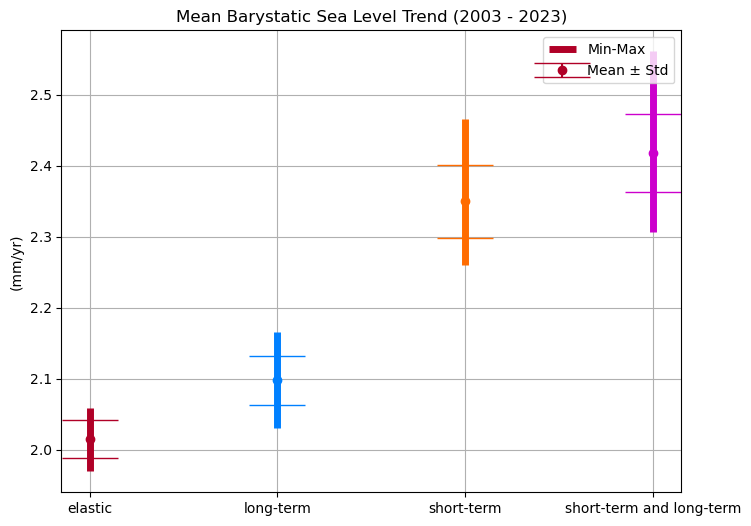

In [33]:
from matplotlib.pyplot import figure, errorbar, vlines, show, grid, title, ylabel, legend
from snrei.scripts.plot.utils import COLORS

# TODO: include variations around a parameter. A errorbar call for value of the parameter and color?
colors = {
    "elastic": COLORS[11],
    "long-term": COLORS[12],
    "short-term": COLORS[13],
    "short-term and long-term": COLORS[14],
}

figure(figsize=(8, 6))

for i in range(len(grouped_df)):
    anelasticity = grouped_df["Anelasticity"][i]
    color = colors[anelasticity]
    errorbar(
        grouped_df["Anelasticity"][i],
        grouped_df["mean"][i],
        yerr=grouped_df["std"][i],
        fmt="o",
        capsize=20,
        label="Mean ± Std" if i == 0 else "",
        color=color,
    )
    vlines(grouped_df["Anelasticity"][i], grouped_df["min"][i], grouped_df["max"][i], colors=color, lw=5, label="Min-Max" if i == 0 else "")

title("Mean Barystatic Sea Level Trend (2003 - 2022)")
ylabel("(mm/yr)")
legend()
grid(True)

show()

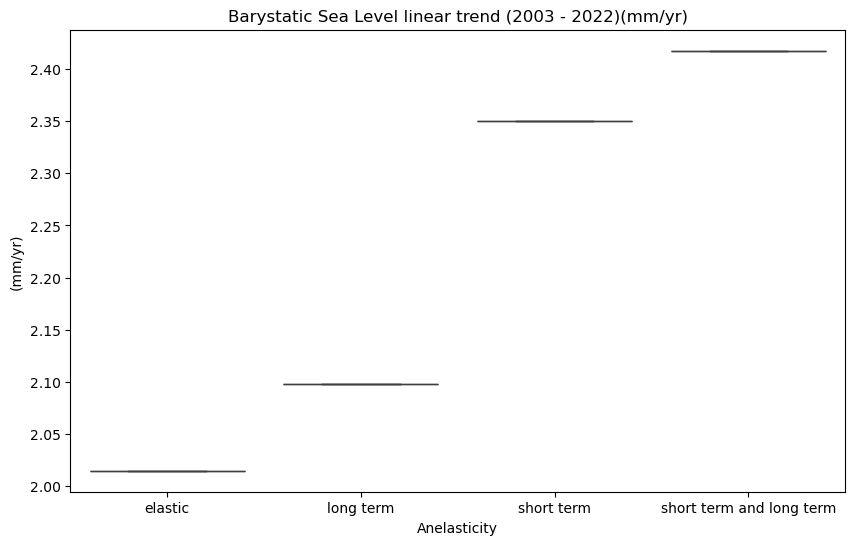

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=grouped_df["Anelasticity"], y=grouped_df["mean"])
plt.title(f"Barystatic Sea Level linear trend (2003 - 2022)(mm/yr)")
plt.ylabel("(mm/yr)")
plt.show()

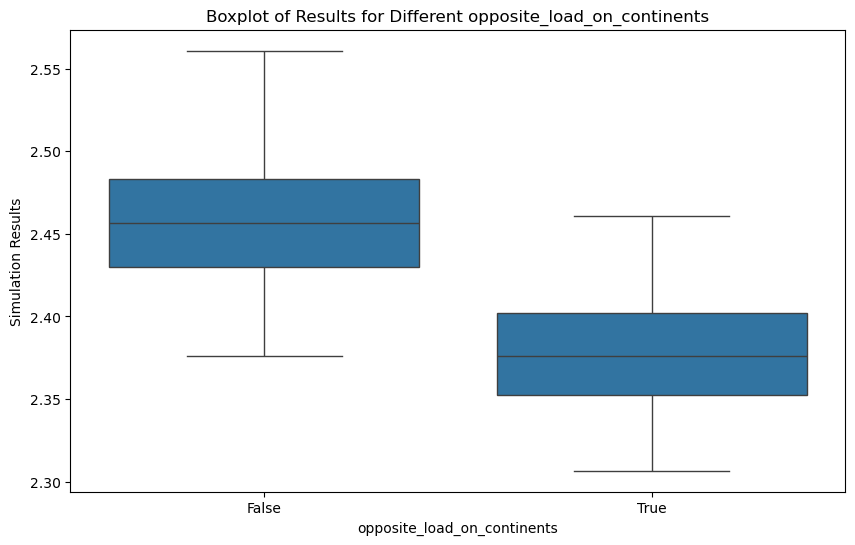

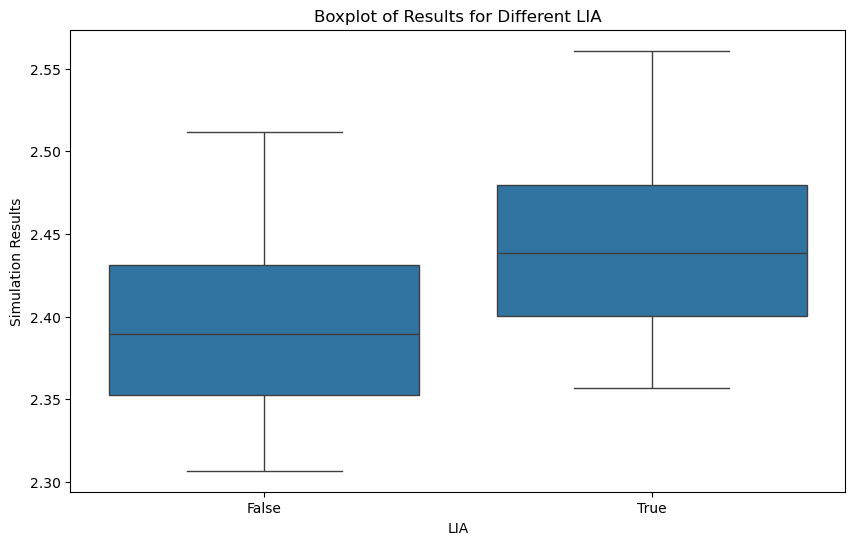

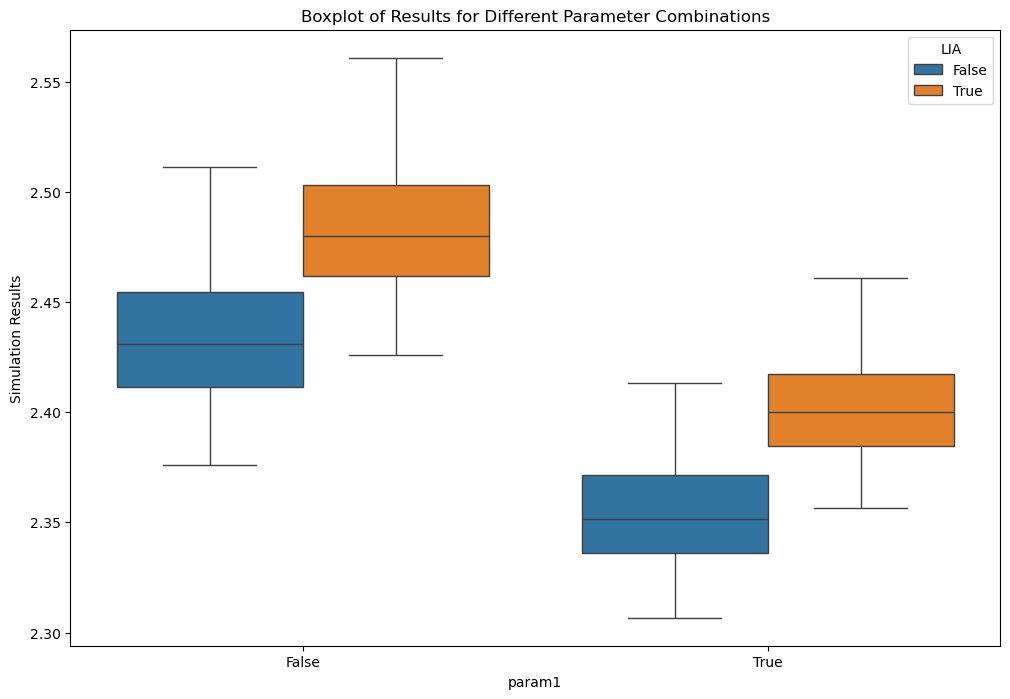

In [25]:


params = ["opposite_load_on_continents", "LIA"]
grouped = both_df.groupby(params)["ocean_mean_step_3"].agg(["mean", "std"]).reset_index()

# If you want to plot each parameter separately:
for param in ["opposite_load_on_continents", "LIA"]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=param, y="ocean_mean_step_3", data=both_df)
    plt.title(f"Boxplot of Results for Different {param}")
    plt.xlabel(param)
    plt.ylabel("Simulation Results")
    plt.show()

# If you want a combined view:
plt.figure(figsize=(12, 8))
sns.boxplot(data=both_df, x="opposite_load_on_continents", y="ocean_mean_step_3", hue="LIA")
plt.title("Boxplot of Results for Different Parameter Combinations")
plt.xlabel("param1")
plt.ylabel("Simulation Results")
plt.show()